In [796]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gs
import sklearn.linear_model
import sklearn.preprocessing
from keras.models import Sequential
from keras.layers import Dense, LSTM
from scipy.stats import linregress
import sklearn.model_selection
%matplotlib inline
import time
import os
np.random.seed(19)

In [170]:
weather = pd.read_csv("dat/weather_2016.csv")

In [171]:
weather["DATE"] = pd.to_datetime(weather.DATE)

In [172]:
weather = weather.groupby("DATE").mean()[["PRCP", "SNOW", "SNWD", "TAVG"]].reset_index()

In [173]:
jan = pd.read_csv("dat/daily_metrics_start_end_node_wise_20160101-20160201.csv")

feb = pd.read_csv("dat/daily_metrics_start_end_node_wise_20160201-20160301.csv")

mar = pd.read_csv("dat/daily_metrics_start_end_node_wise_20160301-20160401.csv")

apr = pd.read_csv("dat/daily_metrics_start_end_node_wise_20160401-20160501.csv")

may = pd.read_csv("dat/daily_metrics_start_end_node_wise_20160501-20160601.csv")

jun = pd.read_csv("dat/daily_metrics_start_end_node_wise_20160601-20160701.csv")

jul = pd.read_csv("dat/daily_metrics_start_end_node_wise_20160701-20160801.csv")

aug = pd.read_csv("dat/daily_metrics_start_end_node_wise_20160801-20160901.csv")

sep = pd.read_csv("dat/daily_metrics_start_end_node_wise_20160901-20161001.csv")

octb = pd.read_csv("dat/daily_metrics_start_end_node_wise_20161001-20161101.csv")

nov = pd.read_csv("dat/daily_metrics_start_end_node_wise_20161101-20161201.csv")

dec = pd.read_csv("dat/daily_metrics_start_end_node_wise_20161201-20170101.csv")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [174]:
taxi_df1 = pd.concat([jan, feb, mar, apr, may, jun])

taxi_df2 = pd.concat([jul, aug, sep, octb, nov, dec])

taxi_df2.rename(columns={"rides_count":"sum"}, inplace=True)

In [175]:
taxi_df1.head()

,dt,quarter_actual,day_name,pickup_location_id,dropoff_location_id,pickup_borough,pickup_zone,dropoff_borough,dropoff_zone,sum,...,dropoff_work_age_55_over,dropoff_work_white,dropoff_work_black,dropoff_work_asian,dropoff_work_others,dropoff_work_two_or_more,dropoff_work_less_high_school,dropoff_work_high_school,dropoff_work_college,dropoff_work_bachelor
0,2016-01-01,1.0,Friday,43.0,161.0,Manhattan,Central Park,Manhattan,Midtown Center,1.0,...,35179.0,142519.0,23942.0,25756.0,1446.0,3477.0,13446.0,23571.0,36647.0,79399.0
1,2016-01-01,1.0,Friday,79.0,80.0,Manhattan,East Village,Brooklyn,East Williamsburg,1.0,...,4342.0,9967.0,4335.0,1882.0,165.0,297.0,2902.0,3533.0,3959.0,3147.0
2,2016-01-01,1.0,Friday,106.0,75.0,Brooklyn,Gowanus,Manhattan,East Harlem South,1.0,...,7102.0,16691.0,8784.0,4696.0,270.0,599.0,3123.0,4830.0,7540.0,10016.0
3,2016-01-01,1.0,Friday,148.0,188.0,Manhattan,Lower East Side,Brooklyn,Prospect-Lefferts Gardens,1.0,...,4556.0,6442.0,6933.0,1956.0,124.0,257.0,1888.0,2825.0,4127.0,4562.0
4,2016-01-01,1.0,Friday,148.0,238.0,Manhattan,Lower East Side,Manhattan,Upper West Side North,1.0,...,3016.0,8857.0,2709.0,1179.0,110.0,227.0,1687.0,2183.0,2903.0,3083.0


In [176]:
taxi_df2.head()

,dt,day_name,quarter_actual,pickup_borough,pickup_zone,pickup_location_id,dropoff_borough,dropoff_zone,dropoff_location_id,sum,...,dropoff_work_age_55_over,dropoff_work_white,dropoff_work_black,dropoff_work_asian,dropoff_work_others,dropoff_work_two_or_more,dropoff_work_less_high_school,dropoff_work_high_school,dropoff_work_college,dropoff_work_bachelor
0,2016-07-01,Friday,3.0,Manhattan,Clinton West,50.0,Manhattan,Financial District North,87.0,1,...,17260.0,54262.0,15843.0,9698.0,616.0,1426.0,6493.0,10840.0,16751.0,31759.0
1,2016-07-01,Friday,3.0,Manhattan,East Village,79.0,Brooklyn,Crown Heights North,61.0,1,...,3178.0,6297.0,5628.0,1153.0,125.0,216.0,1728.0,2436.0,3166.0,3325.0
2,2016-07-01,Friday,3.0,Manhattan,SoHo,211.0,Brooklyn,Downtown Brooklyn/MetroTech,65.0,1,...,18431.0,27164.0,27038.0,6378.0,611.0,1232.0,7402.0,14292.0,19041.0,16264.0
3,2016-07-01,Friday,3.0,Manhattan,TriBeCa/Civic Center,231.0,Manhattan,Clinton West,50.0,1,...,4316.0,17648.0,5053.0,2590.0,186.0,412.0,2044.0,3652.0,5257.0,9108.0
4,2016-07-01,Friday,3.0,Manhattan,TriBeCa/Civic Center,231.0,Manhattan,Lenox Hill East,140.0,1,...,9266.0,23410.0,9875.0,6012.0,321.0,761.0,3441.0,5852.0,9969.0,13958.0


In [177]:
taxi_df1 = taxi_df1[["dt", "pickup_location_id","dropoff_location_id", "sum"]]

taxi_df2 = taxi_df2[["dt", "pickup_location_id","dropoff_location_id", "sum"]]

In [178]:
taxi_df = pd.concat([taxi_df1, taxi_df2])

In [179]:
taxi_df = taxi_df.loc[~taxi_df.dt.str.contains("2017")]

In [180]:
taxi_df.dropna(subset=["pickup_location_id", "dropoff_location_id"], inplace=True)

In [181]:
taxi_df =\
taxi_df.groupby(["dt", "pickup_location_id"]).sum().reset_index()[["dt", "pickup_location_id", "sum"]]

In [182]:
taxi_df["date"] = pd.to_datetime(taxi_df["dt"])

In [183]:
taxi_df["dow"] = taxi_df.date.dt.dayofweek

In [184]:
taxi_df["month"] = taxi_df.date.dt.month

In [185]:
taxi_df.head()

,dt,pickup_location_id,sum,date,dow,month
0,2016-01-01,1.0,18.0,2016-01-01,4,1
1,2016-01-01,3.0,4.0,2016-01-01,4,1
2,2016-01-01,4.0,1781.0,2016-01-01,4,1
3,2016-01-01,6.0,1.0,2016-01-01,4,1
4,2016-01-01,7.0,2086.0,2016-01-01,4,1


In [186]:
taxi_df = taxi_df.merge(weather, how="left", left_on="date", right_on="DATE")

In [187]:
taxi_df.drop("dt", inplace=True, axis=1)

In [188]:
taxi_df.head()

,pickup_location_id,sum,date,dow,month,DATE,PRCP,SNOW,SNWD,TAVG
0,1.0,18.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667
1,3.0,4.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667
2,4.0,1781.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667
3,6.0,1.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667
4,7.0,2086.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667


In [900]:
lin_reg.fit(taxi_df.groupby("date").mean()["TAVG"].values.reshape(-1, 1), taxi_df.groupby("date").sum()["sum"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [902]:
x_ = taxi_df.groupby("date").mean()["TAVG"].values.reshape(-1, 1)
x_.sort()

In [903]:
preds = lin_reg.predict(x_)

In [910]:
r2 = lin_reg.score(taxi_df.groupby("date").mean()["TAVG"].values.reshape(-1, 1), taxi_df.groupby("date").sum()["sum"].values.reshape(-1, 1))

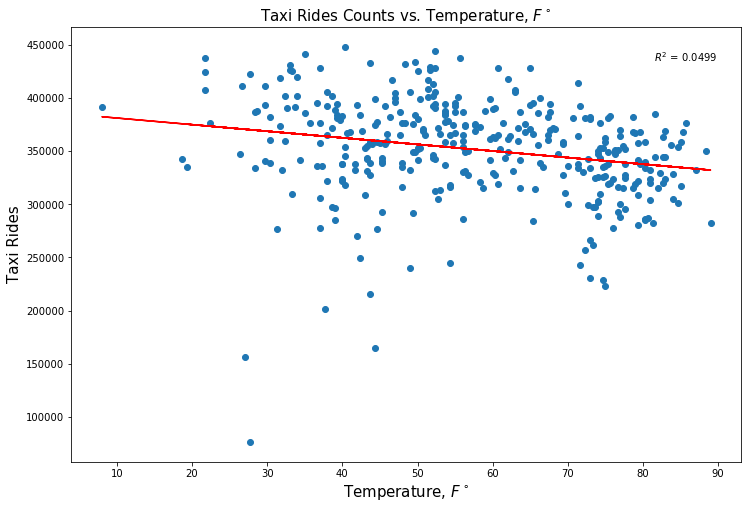

In [921]:
fig, ax = plt.subplots()

fig.set_size_inches(2 * fig.get_size_inches())

ax.scatter(taxi_df.groupby("date").mean()["TAVG"], taxi_df.groupby("date").sum()["sum"])

ax.plot(x_, preds, color="red")



ax.text(x=.87, y=.92, transform=ax.transAxes, s="$R^2$ = " + str(round(r2, 4)))

ax.set_xlabel("Temperature, $F^\circ$", size=15)

ax.set_ylabel("Taxi Rides", size=15)

ax.set_title("Taxi Rides Counts vs. Temperature, $F^\circ$", size=15)

fig.savefig("taxi_temp_scatter.png", b_box_inches="tight")

In [958]:
cum_ = taxi_df.groupby("pickup_location_id").sum()["sum"].values

cum_.sort()

cum_ = np.flip(cum_, axis=-1)

tot = cum_.sum()

cum_ /= tot

cum_ = cum_.cumsum()

In [968]:
cum_[49]

0.94908581370009459

In [971]:
len(cum_)

260

In [1039]:
taxi_df.groupby("date").sum()["sum"].loc[taxi_df.groupby("date").sum()["sum"] == taxi_df.groupby("date").sum()["sum"].min()]

date
2016-01-23    76372.0
Name: sum, dtype: float64

In [1059]:
wks = pd.date_range(start="1/1/2016", end="1/1/2017", freq="2W-FRI", ).date

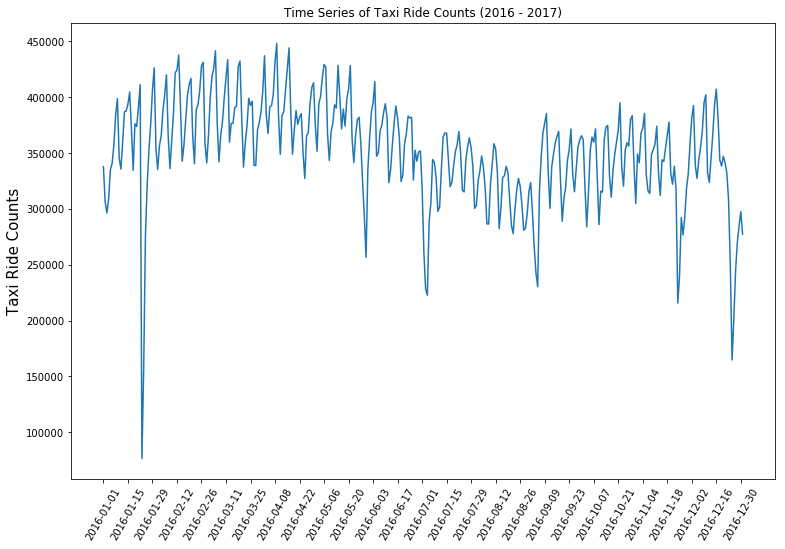

In [1062]:
fig_tx_ts, ax = plt.subplots()

fig_tx_ts.set_size_inches(2.1 * fig_tx_ts.get_size_inches())

ax.plot(taxi_df.groupby("date").sum().index, taxi_df.groupby("date").sum()["sum"])

ax.set_xticks(wks)

ax.set_xticklabels(wks, rotation=60)

ax.set_ylabel("Taxi Ride Counts", size=15)

ax.set_title("Time Series of Taxi Ride Counts (2016 - 2017)")

fig_tx_ts.savefig("ts_taxi_rides_prelim", b_box_inches="tight")

In [1030]:
taxi_df.groupby("date").sum()["sum"]

date
2016-01-01    337849.0
2016-01-02    306225.0
2016-01-03    296378.0
2016-01-04    309178.0
2016-01-05    335230.0
2016-01-06    341051.0
2016-01-07    357456.0
2016-01-08    384123.0
2016-01-09    398721.0
2016-01-10    345890.0
2016-01-11    335667.0
2016-01-12    359892.0
2016-01-13    386845.0
2016-01-14    387783.0
2016-01-15    393857.0
2016-01-16    404716.0
2016-01-17    372103.0
2016-01-18    334512.0
2016-01-19    376284.0
2016-01-20    373845.0
2016-01-21    390943.0
2016-01-22    411182.0
2016-01-23     76372.0
2016-01-24    156693.0
2016-01-25    276490.0
2016-01-26    321720.0
2016-01-27    352572.0
2016-01-28    375989.0
2016-01-29    405956.0
2016-01-30    426374.0
                ...   
2016-12-02    381933.0
2016-12-03    392554.0
2016-12-04    338875.0
2016-12-05    327397.0
2016-12-06    343845.0
2016-12-07    355004.0
2016-12-08    369139.0
2016-12-09    395315.0
2016-12-10    402182.0
2016-12-11    332452.0
2016-12-12    323678.0
2016-12-13    345523.0
2016-1

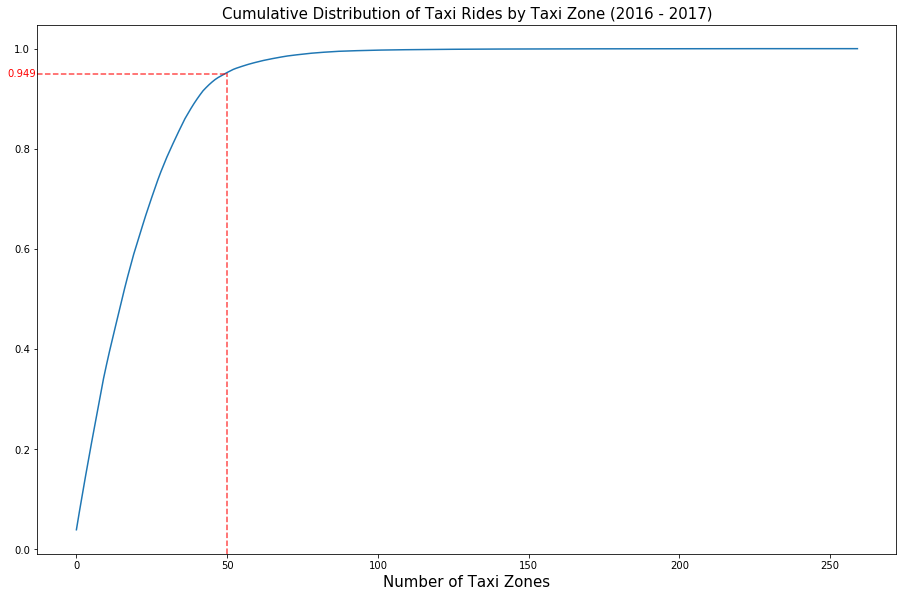

In [1029]:
fig_cum, ax = plt.subplots()

fig_cum.set_size_inches(2.1 * fig_cum.get_size_inches())

ax.plot(np.arange(0, cum_.shape[0]), cum_)

ax.axvline(x=50, linestyle="--", color="red", alpha=.7, ymax=cum_[49] - .04)

# ax.margins(x=.01, y=.01)

ax.set_xlabel("Number of Taxi Zones", size=15)

# ax.set_ylabel("Proportion of Total Taxi Ride Volume", size=15)

ax.set_title("Cumulative Distribution of Taxi Rides by Taxi Zone (2016 - 2017)", size=15)

ax.axhline(y=cum_[49], linestyle="--", color="red", xmax=57.5 / len(cum_), alpha=.7)

ax.text(x=-22.95, y=cum_[49] - .005, s=round(cum_[49], 3), color="red")

fig_cum.tight_layout()

fig_cum.savefig("cum_dist_taxi_rides.png", b_box_inches="tight")

In [894]:
taxi_df.groupby("date").sum()["sum"]

date
2016-01-01    337849.0
2016-01-02    306225.0
2016-01-03    296378.0
2016-01-04    309178.0
2016-01-05    335230.0
2016-01-06    341051.0
2016-01-07    357456.0
2016-01-08    384123.0
2016-01-09    398721.0
2016-01-10    345890.0
2016-01-11    335667.0
2016-01-12    359892.0
2016-01-13    386845.0
2016-01-14    387783.0
2016-01-15    393857.0
2016-01-16    404716.0
2016-01-17    372103.0
2016-01-18    334512.0
2016-01-19    376284.0
2016-01-20    373845.0
2016-01-21    390943.0
2016-01-22    411182.0
2016-01-23     76372.0
2016-01-24    156693.0
2016-01-25    276490.0
2016-01-26    321720.0
2016-01-27    352572.0
2016-01-28    375989.0
2016-01-29    405956.0
2016-01-30    426374.0
                ...   
2016-12-02    381933.0
2016-12-03    392554.0
2016-12-04    338875.0
2016-12-05    327397.0
2016-12-06    343845.0
2016-12-07    355004.0
2016-12-08    369139.0
2016-12-09    395315.0
2016-12-10    402182.0
2016-12-11    332452.0
2016-12-12    323678.0
2016-12-13    345523.0
2016-1

In [189]:
import sklearn.preprocessing

scaler = sklearn.preprocessing.StandardScaler()

In [190]:
yelp_counts = pd.read_csv("yelp_ads.csv")[["LocationID", "counts"]]

In [191]:
taxi_df =\
taxi_df.merge(yelp_counts, how="left", left_on="pickup_location_id", right_on="LocationID").drop("LocationID", axis=1)

taxi_df.rename(columns={"counts":"yelp_bars"}, inplace=True)

In [192]:
taxi_df.head()

,pickup_location_id,sum,date,dow,month,DATE,PRCP,SNOW,SNWD,TAVG,yelp_bars
0,1.0,18.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,2.0
1,3.0,4.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,1.0
2,4.0,1781.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,31.0
3,6.0,1.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,1.0
4,7.0,2086.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,103.0


In [193]:
taxi_df_modeling = taxi_df.dropna()

In [194]:
from sklearn.linear_model import LinearRegression

In [799]:
lin_reg = LinearRegression()

In [800]:
x1, y1 = taxi_df_modeling[["PRCP", "SNOW", "SNWD", "TAVG", "yelp_bars"]].values, taxi_df_modeling["sum"].values.reshape(-1, 1)

In [801]:
lin_reg.fit(x1, y1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [802]:
lin_reg.score(x1, y1)

0.24241802494198894

In [803]:
np.sqrt(((lin_reg.predict(x1) - y1) ** 2).sum() / len(y1))

3041.2271696021025

In [889]:
taxi_df_modeling

,pickup_location_id,sum,date,dow,month,DATE,PRCP,SNOW,SNWD,TAVG,yelp_bars
0,1.0,18.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,2.0
1,3.0,4.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,1.0
2,4.0,1781.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,31.0
3,6.0,1.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,1.0
4,7.0,2086.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,103.0
6,9.0,2.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,7.0
7,10.0,33.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,1.0
8,11.0,5.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,4.0
10,13.0,2618.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,13.0
11,14.0,90.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,37.0


In [805]:
x1.shape, y1.shape

((69687, 5), (69687, 1))

In [809]:
x1.T.shape

(5, 69687)

In [820]:
import statsmodels.formula.api as smf

In [822]:
reg_sum = smf.OLS(y1, x1).fit()

In [827]:
reg_sum.pvalues

array([  9.19001041e-001,   1.64968870e-004,   6.98422559e-001,
         2.01732230e-210,   0.00000000e+000])

In [831]:
reg_sum.pvalues[]

SyntaxError: invalid syntax (<ipython-input-831-62e80d089972>, line 1)

In [823]:
reg_sum.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     9437.
Date:                Wed, 19 Dec 2018   Prob (F-statistic):               0.00
Time:                        12:50:39   Log-Likelihood:            -6.5794e+05
No. Observations:               69687   AIC:                         1.316e+06
Df Residuals:                   69682   BIC:                         1.316e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -4.5713     44.952     -0.102      0.919     -92.677      83.535
x2           -34.1015      9.051     -3.768      0.000     -51.842     -16.361
x3            -2.0155      5.202     -0.387      0.698     -12.211       8.180
x4             7.6836      0.247     31.064      0.000       7.199       8.168
x5            78.7603      0.506    155.708      0.000      77.769      79.752
==============================================================================
Omnibus:                    23656.830   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            86933.179
Skew:                           1.695   Prob(JB):                         0.00
Kurtosis:                       7.295   Cond. No.                         244.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [817]:
a, b, c, d = linregress(x1[:,0], y1)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [751]:
taxi_df.groupby("date").mean()["dow", "month", "PRCP", "SNOW", "SNWD", "TAVG"]

,pickup_location_id,sum,dow,month,PRCP,SNOW,SNWD,TAVG,yelp_bars
date,,,,,,,,,
2016-01-01,133.073276,1456.245690,4,1,0.0,0.0,0.0,41.666667,16.396040
2016-01-02,137.665072,1465.191388,5,1,0.0,0.0,0.0,37.000000,17.410811
2016-01-03,134.701357,1341.076923,6,1,0.0,0.0,0.0,39.000000,16.644670
2016-01-04,136.167442,1438.037209,0,1,0.0,0.0,0.0,33.333333,17.100000
2016-01-05,134.563380,1573.849765,1,1,0.0,0.0,0.0,19.333333,17.262032


In [833]:
one_hots_ntwk = taxi_df.groupby("date").mean()[["dow", "month"]].values

In [834]:
x_ntwk = taxi_df.groupby("date").mean()[["PRCP", "SNOW", "SNWD", "TAVG"]].values

In [835]:
y_ntwk = taxi_df.groupby("date").sum()["sum"].values.reshape(-1, 1)

In [836]:
one_hots_ntwk.shape, x_ntwk.shape, y_ntwk.shape

((366, 2), (366, 4), (366, 1))

In [837]:
x_ntwk = np.hstack((x_ntwk, one_hot.fit_transform(one_hots_ntwk).toarray()))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [838]:
x_ntwk.shape

(366, 23)

In [839]:
lin_reg.fit(x_ntwk, y_ntwk)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [840]:
lin_reg.score(x_ntwk, y_ntwk)

0.64562238951339035

In [841]:
np.sqrt(((lin_reg.predict(x_ntwk) - y_ntwk) ** 2).sum() / len(x_ntwk))

27897.743516396331

In [848]:
one_hot_sum = smf.OLS(y_ntwk, x_ntwk).fit()

In [849]:
x_ntwk.shape

(366, 23)

In [850]:
y_ntwk.shape

(366, 1)

In [ ]:
# prcp, snow, snwd, tavg

In [859]:
one_hot_sum.params[:4]

array([  1314.77364963, -10453.55522531,  -3510.68079552,   -836.58222104])

In [864]:
weather_ = taxi_df[["PRCP", "SNOW", "SNWD","TAVG", "yelp_bars"]].values

In [865]:
taxi_df.head()

,pickup_location_id,sum,date,dow,month,DATE,PRCP,SNOW,SNWD,TAVG,yelp_bars
0,1.0,18.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,2.0
1,3.0,4.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,1.0
2,4.0,1781.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,31.0
3,6.0,1.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,1.0
4,7.0,2086.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,103.0


In [ ]:
one_hots_node[["dow", "month", ""]]

In [856]:
one_hot_sum.coef[:4]

AttributeError: 'OLSResults' object has no attribute 'coef'

In [852]:
one_hot_sum.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     29.84
Date:                Wed, 19 Dec 2018   Prob (F-statistic):           1.05e-64
Time:                        13:06:53   Log-Likelihood:                -4265.8
No. Observations:                 366   AIC:                             8576.
Df Residuals:                     344   BIC:                             8661.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1314.7736   6018.461      0.218      0.827   -1.05e+04    1.32e+04
x2         -1.045e+04   1196.496     -8.737      0.000   -1.28e+04   -8100.187
x3         -3510.6808    766.125     -4.582      0.000   -5017.559   -2003.803
x4          -836.5822    215.480     -3.882      0.000   -1260.407    -412.757
x5          2.175e+05   8477.684     25.655      0.000    2.01e+05    2.34e+05
x6          2.456e+05   8627.003     28.472      0.000    2.29e+05    2.63e+05
x7          2.587e+05   8783.608     29.451      0.000    2.41e+05    2.76e+05
x8          2.713e+05   8881.763     30.541      0.000    2.54e+05    2.89e+05
x9          2.781e+05   8736.316     31.827      0.000    2.61e+05    2.95e+05
x10         2.765e+05   8609.209     32.111      0.000     2.6e+05    2.93e+05
x11         2.293e+05   8631.337     26.564      0.000    2.12e+05    2.46e+05
x12         1.415e+05   5658.545     25.005      0.000     1.3e+05    1.53e+05
x13         1.667e+05   5170.949     32.245      0.000    1.57e+05    1.77e+05
x14         1.728e+05   5594.365     30.892      0.000    1.62e+05    1.84e+05
x15         1.783e+05   6120.306     29.125      0.000    1.66e+05     1.9e+05
x16         1.751e+05   7403.057     23.646      0.000     1.6e+05     1.9e+05
x17         1.708e+05   9311.380     18.345      0.000    1.53e+05    1.89e+05
x18         1.379e+05   1.05e+04     13.132      0.000    1.17e+05    1.59e+05
x19         1.293e+05   1.06e+04     12.161      0.000    1.08e+05     1.5e+05
x20         1.367e+05   9265.654     14.750      0.000    1.18e+05    1.55e+05
x21         1.409e+05   7055.686     19.975      0.000    1.27e+05    1.55e+05
x22         1.191e+05   5967.105     19.953      0.000    1.07e+05    1.31e+05
x23         1.079e+05   5032.832     21.431      0.000     9.8e+04    1.18e+05
==============================================================================
Omnibus:                      140.421   Durbin-Watson:                   0.476
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              518.665
Skew:                          -1.694   Prob(JB):                    2.36e-113
Kurtosis:                       7.747   Cond. No.                     7.63e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.25e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [200]:
import sklearn.preprocessing

In [201]:
import sklearn.model_selection

In [202]:
scaler = sklearn.preprocessing.StandardScaler()

In [203]:
one_hot = sklearn.preprocessing.OneHotEncoder()

In [204]:
taxi_df.head()

,pickup_location_id,sum,date,dow,month,DATE,PRCP,SNOW,SNWD,TAVG,yelp_bars
0,1.0,18.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,2.0
1,3.0,4.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,1.0
2,4.0,1781.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,31.0
3,6.0,1.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,1.0
4,7.0,2086.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,103.0


In [205]:
taxi_df[["PRCP", "SNOW", "SNWD", "TAVG", "yelp_bars"]].head()

,PRCP,SNOW,SNWD,TAVG,yelp_bars
0,0.0,0.0,0.0,41.666667,2.0
1,0.0,0.0,0.0,41.666667,1.0
2,0.0,0.0,0.0,41.666667,31.0
3,0.0,0.0,0.0,41.666667,1.0
4,0.0,0.0,0.0,41.666667,103.0


In [867]:
x1.shape

(69687, 5)

In [869]:
one_hot_vars =\
one_hot.fit_transform(taxi_df_modeling[["dow", "month", "pickup_location_id"]].values).toarray()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [872]:
x_final = np.hstack((x1, one_hot_vars))

In [873]:
x_final.shape

(69687, 242)

In [874]:
from sklearn.model_selection import train_test_split

In [875]:
x_train, x_test, y_train, y_test = train_test_split(x_final, y1)

In [876]:
lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [877]:
lin_reg.score(x_train, y_train)

0.95279054423572973

In [878]:
lin_reg.score(x_test, y_test)

0.95245534889124495

In [879]:
np.sqrt(((lin_reg.predict(x_test) - y_test) ** 2).sum() / len(y_test))

751.62569055362042

In [880]:
y1.shape

(69687, 1)

In [890]:
x_final.shape

(69687, 242)

In [891]:
y1.shape

(69687, 1)

In [881]:
node_level_dummy = smf.OLS(y1, x_final).fit()

In [884]:
node_level_dummy.params[:5]

array([  8.63799636, -55.64104138, -17.90058328,  -4.39961699,  79.648674  ])

In [887]:
node_level_dummy.pvalues[:5]

array([  4.55387170e-001,   8.63447432e-128,   1.08706643e-034,
         1.54345685e-026,   0.00000000e+000])

In [ ]:
# "PRCP", "SNOW", "SNWD", "TAVG", "yelp_bars"

In [882]:
node_level_dummy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     5885.
Date:                Wed, 19 Dec 2018   Prob (F-statistic):               0.00
Time:                        13:28:19   Log-Likelihood:            -5.6109e+05
No. Observations:               69687   AIC:                         1.123e+06
Df Residuals:                   69448   BIC:                         1.125e+06
Df Model:                         238                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             8.6380     11.572      0.746      0.455     -14.043      31.319
x2           -55.6410      2.309    -24.099      0.000     -60.166     -51.116
x3           -17.9006      1.456    -12.292      0.000     -20.755     -15.046
x4            -4.3996      0.412    -10.666      0.000      -5.208      -3.591
x5            79.6487      0.140    570.337      0.000      79.375      79.922
x6           199.5770     16.033     12.448      0.000     168.152     231.002
x7           348.7726     16.307     21.388      0.000     316.810     380.735
x8           417.8460     16.606     25.163      0.000     385.299     450.393
x9           484.1303     16.767     28.873      0.000     451.266     516.995
x10          516.9238     16.465     31.395      0.000     484.653     549.195
x11          505.2939     16.199     31.194      0.000     473.545     537.043
x12          264.2030     16.243     16.266      0.000     232.367     296.039
x13          193.6228     10.923     17.726      0.000     172.214     215.032
x14          325.4202      9.980     32.608      0.000     305.860     344.981
x15          356.7500     10.674     33.423      0.000     335.829     377.671
x16          385.8162     11.629     33.178      0.000     363.024     408.608
x17          368.7380     14.041     26.261      0.000     341.217     396.259
x18          347.5196     17.658     19.681      0.000     312.910     382.129
x19          176.3093     19.897      8.861      0.000     137.311     215.308
x20          129.9713     20.165      6.445      0.000      90.448     169.495
x21          169.2464     17.590      9.622      0.000     134.770     203.722
x22          191.3821     13.422     14.258      0.000     165.074     217.690
x23           75.4405     11.401      6.617      0.000      53.094      97.787
x24           16.5302      9.730      1.699      0.089      -2.541      35.601
x25         -494.6558     39.825    -12.421      0.000    -572.713    -416.598
x26         -444.1820     52.363     -8.483      0.000    -546.814    -341.550
x27        -1725.7424     39.659    -43.515      0.000   -1803.473   -1648.011
x28         -402.2169     51.523     -7.806      0.000    -503.203    -301.231
x29        -7879.8294     38.246   -206.028      0.000   -7954.792   -7804.867
x30         -910.5524     52.516    -17.339      0.000   -1013.484    -807.621
x31         -372.8013     39.771     -9.374      0.000    -450.752    -294.851
x32         -675.8810     43.177    -15.654      0.000    -760.508    -591.254
x33         2008.9802     39.759     50.529      0.000    1931.053    2086.907
x34        -3285.5443     39.603    -82.961      0.000   -3363.167   -3207.922
x35         -793.6918     65.753    -12.071      0.000    -922.567    -664.817
x36        -1870.1449     47.459    -39.406      0.000   -1963.164   -1777.126
x3

,pickup_location_id,sum,date,dow,month,DATE,PRCP,SNOW,SNWD,TAVG,yelp_bars
0,1.0,18.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,2.0
1,3.0,4.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,1.0
2,4.0,1781.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,31.0
3,6.0,1.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,1.0
4,7.0,2086.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,103.0
5,8.0,4.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,NaN
6,9.0,2.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,7.0
7,10.0,33.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,1.0
8,11.0,5.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,4.0
9,12.0,186.0,2016-01-01,4,1,2016-01-01,0.0,0.0,0.0,41.666667,NaN


In [662]:
taxi_df_nn =\
taxi_df.groupby("date").sum().reset_index()[["date", "sum"]]

In [729]:
morn_hts = taxi_df.loc[taxi_df.pickup_location_id == 166.0][["date", "sum"]]

In [730]:
morn_hts.shape

(366, 2)

In [663]:
def run_nn(data):

    window_size = 7

    dataset = data["sum"].values.reshape(-1, 1)

    data_x, data_y = [], []

    for i in range(len(dataset) -  window_size - 1):

        data_x.append(dataset[i:(i + window_size)])

        data_y.append(dataset[i])

    data_x = np.array(data_x)

    data_y = np.array(data_y)

    data_x = data_x.reshape(data_x.shape[0], data_x.shape[2], data_x.shape[1])

    data_y = data_y.reshape(data_y.shape[0], 1, 1)

    test_size = 60

    data_x_test = data_x[-test_size:]

    data_y_test = data_y[-test_size:]

    data_x = data_x[:-test_size]

    data_y = data_y[:-test_size]

    np.random.seed(19)

    model = Sequential()

    model.add(LSTM(32, input_shape=(1, window_size), return_sequences=True))




    model.add(Dense(400, activation="relu"))

    model.add(Dense(32, activation="relu"))

    model.add(Dense(100, activation="relu"))

    model.add(Dense(80, activation="relu"))

    model.add(Dense(200, activation="relu"))

    model.add(Dense(16, activation="relu"))

    model.add(Dense(1))

    model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics = ['mse'])

    model.fit(data_x, data_y, epochs=25)
    
    return model, data_x, data_y, data_x_test, data_y_test

In [731]:
model, x_train, y_train, x_test, y_test = run_nn(morn_hts)

Epoch 1/25
298/298 [==============================] - 10s 33ms/step - loss: 3153526.7802 - mean_squared_error: 3153526.7802
Epoch 2/25
298/298 [==============================] - 1s 3ms/step - loss: 3144479.1963 - mean_squared_error: 3144479.1963
Epoch 3/25
298/298 [==============================] - 1s 3ms/step - loss: 3076027.4312 - mean_squared_error: 3076027.4312
Epoch 4/25
298/298 [==============================] - 1s 3ms/step - loss: 2696815.5403 - mean_squared_error: 2696815.5403
Epoch 5/25
298/298 [==============================] - 1s 3ms/step - loss: 1262700.8297 - mean_squared_error: 1262700.8297
Epoch 6/25
298/298 [==============================] - 1s 3ms/step - loss: 378501.7777 - mean_squared_error: 378501.7777
Epoch 7/25
298/298 [==============================] - 1s 3ms/step - loss: 209609.1247 - mean_squared_error: 209609.1247
Epoch 8/25
298/298 [==============================] - 1s 2ms/step - loss: 196593.7053 - mean_squared_error: 196593.7053
Epoch 9/25
298/298 [========

In [732]:
morn_hts_os = np.sqrt(((model.predict(x_test) - y_test) ** 2).sum() / len(x_test))

In [733]:
morn_hts_is = np.sqrt(((model.predict(x_train) - y_train) ** 2).sum() / len(x_train))

In [734]:
test_size = 60

In [742]:
y_test

array([[[ 1856.]],

       [[ 1812.]],

       [[ 2431.]],

       [[ 2270.]],

       [[ 1726.]],

       [[ 1634.]],

       [[ 1737.]],

       [[ 1923.]],

       [[ 1872.]],

       [[ 1868.]],

       [[ 1886.]],

       [[ 1720.]],

       [[ 1432.]],

       [[ 1650.]],

       [[ 1467.]],

       [[ 1858.]],

       [[ 1964.]],

       [[ 1814.]],

       [[ 1680.]],

       [[ 1510.]],

       [[ 1575.]],

       [[ 1915.]],

       [[ 1757.]],

       [[ 2008.]],

       [[ 1956.]],

       [[ 1875.]],

       [[ 1613.]],

       [[ 1829.]],

       [[ 2229.]],

       [[ 1907.]],

       [[ 1257.]],

       [[  824.]],

       [[  930.]],

       [[ 1039.]],

       [[ 1484.]],

       [[ 1871.]],

       [[ 1915.]],

       [[ 1985.]],

       [[ 2119.]],

       [[ 1611.]],

       [[ 1509.]],

       [[ 1762.]],

       [[ 1922.]],

       [[ 1777.]],

       [[ 2052.]],

       [[ 2156.]],

       [[ 1871.]],

       [[ 1591.]],

       [[ 1715.]],

       [[ 1758.]],



In [741]:
preds_

array([[ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1263.91552734],
       [  995.74072266],
       [  995.74072266],
       [ 1901.7722168 ],
       [ 1534.01831055],
       [ 1754.09191895],
       [ 1754.09191895],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1624.81530762],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],
       [ 1754.09204102],


In [738]:
preds = model.predict(x_train).reshape(-1, 1)

In [739]:
preds_ = model.predict(x_test).reshape(-1, 1)

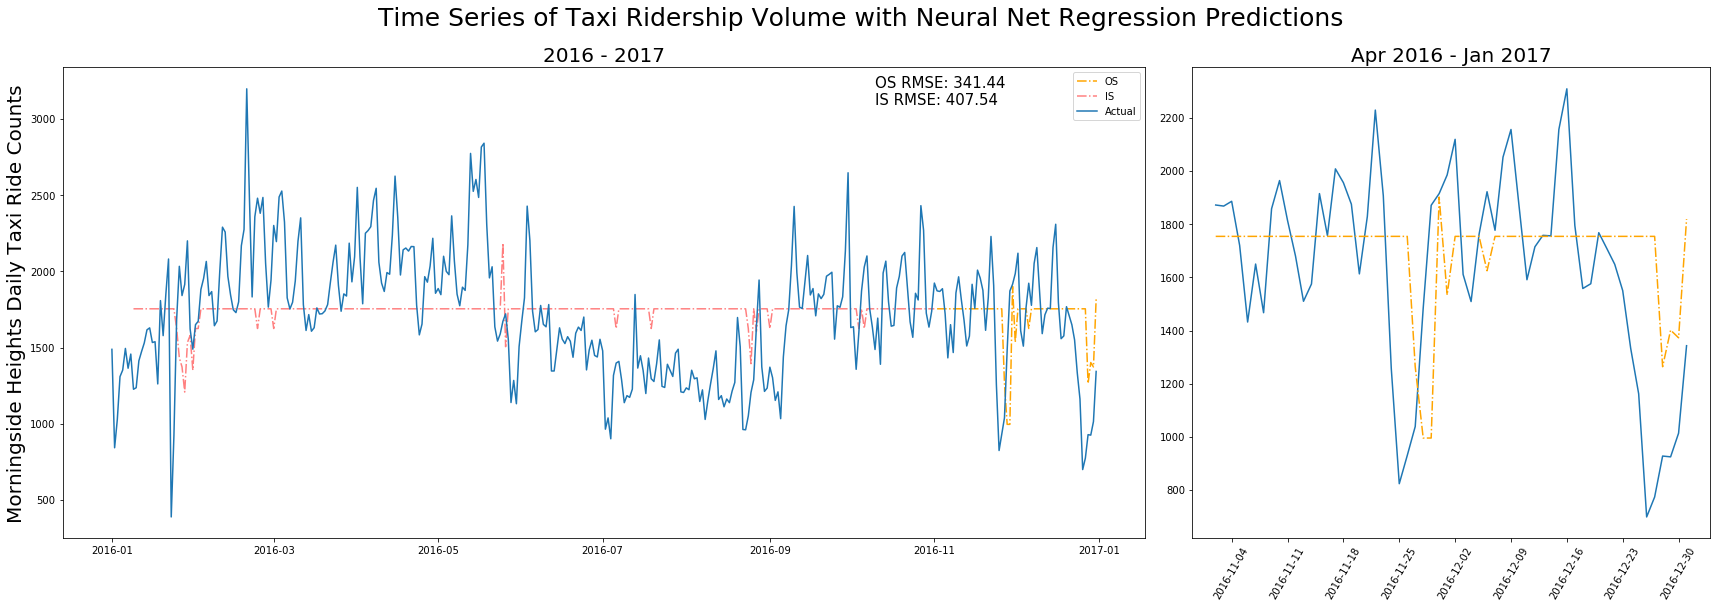

In [744]:
fig = plt.figure(figsize=(24, 8))

ax1 = fig.add_subplot(grid[:, :8])

ax1.plot(morn_hts.iloc[-test_size:]["date"], preds_, color="orange", linestyle="-.", label="OS")

ax1.plot(morn_hts.iloc[8:-test_size]["date"], preds, color="red", alpha=.5, linestyle="-.", label="IS")

ax1.plot(morn_hts["date"], morn_hts["sum"], label="Actual")

ax1.legend()

ax2 = fig.add_subplot(grid[:, 8:])

ax2.plot(morn_hts.iloc[-test_size:]["date"], morn_hts.iloc[-test_size:]["sum"])

ax2.plot(morn_hts.iloc[-test_size:]["date"], preds_, color="orange", linestyle="-.")

plt.xticks(rotation=60)

fig.suptitle("Time Series of Taxi Ridership Volume with Neural Net Regression Predictions", x = .5, y=1.05, size=25)

ax1.set_title("2016 - 2017", size=20)

ax2.set_title("Apr 2016 - Jan 2017", size=20)

ax1.set_ylabel("Morningside Heights Daily Taxi Ride Counts", size=20)

ax1.text(x=.75, y=.92, transform=ax1.transAxes, s="OS RMSE: {}\nIS RMSE: {}".format(round(morn_hts_os, 2),\
                                                                                  round(morn_hts_is, 2)), size=15)

fig.tight_layout()

fig.savefig("mornhts_taxi_timeseries_nn.png", b_box_inches="tight")

In [586]:
taxi_df_nn =\
taxi_df.groupby("date").sum().reset_index()[["date", "sum"]]

In [587]:
window_size = 7

In [588]:
dataset = taxi_df_nn["sum"].values.reshape(-1, 1)

In [589]:
dataset.shape

(366, 1)

In [590]:
data_x, data_y = [], []

In [591]:
for i in range(len(dataset) -  window_size - 1):
    
    data_x.append(dataset[i:(i + window_size)])
    
    data_y.append(dataset[i])
    
data_x = np.array(data_x)

data_y = np.array(data_y)

In [592]:
data_x = data_x.reshape(data_x.shape[0], data_x.shape[2], data_x.shape[1])

In [593]:
data_y = data_y.reshape(data_y.shape[0], 1, 1)

In [594]:
data_x.shape

(358, 1, 7)

In [595]:
data_y.shape

(358, 1, 1)

In [596]:
test_size = 60

In [597]:
data_x_test = data_x[-test_size:]

data_y_test = data_y[-test_size:]

data_x = data_x[:-test_size]

data_y = data_y[:-test_size]

In [598]:
np.random.seed(19)

model = Sequential()

model.add(LSTM(32, input_shape=(1, window_size), return_sequences=True))




model.add(Dense(400, activation="relu"))

model.add(Dense(32, activation="relu"))

model.add(Dense(100, activation="relu"))

model.add(Dense(80, activation="relu"))

model.add(Dense(200, activation="relu"))

model.add(Dense(16, activation="relu"))

model.add(Dense(1))

In [599]:
model.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics = ['mse'])

In [600]:
model.fit(data_x, data_y, epochs=25)

Epoch 1/25
298/298 [==============================] - 5s 17ms/step - loss: 128882224574.7114 - mean_squared_error: 128882224574.7114
Epoch 2/25
298/298 [==============================] - 0s 496us/step - loss: 128880693880.2685 - mean_squared_error: 128880693880.2685
Epoch 3/25
298/298 [==============================] - 0s 472us/step - loss: 128870410116.2953 - mean_squared_error: 128870410116.2953
Epoch 4/25
298/298 [==============================] - 0s 427us/step - loss: 128811524755.7584 - mean_squared_error: 128811524755.7584
Epoch 5/25
298/298 [==============================] - 0s 456us/step - loss: 128526185465.1275 - mean_squared_error: 128526185465.1275
Epoch 6/25
298/298 [==============================] - 0s 481us/step - loss: 127343255771.9195 - mean_squared_error: 127343255771.9195
Epoch 7/25
298/298 [==============================] - 0s 480us/step - loss: 123214496293.7986 - mean_squared_error: 123214496293.7986
Epoch 8/25
298/298 [==============================] - 0s 507us/

In [641]:
rmse_is = np.sqrt(((model.predict(data_x) - data_y) ** 2).sum() / len(data_y))   #IS

In [642]:
rmse_os = np.sqrt(((model.predict(data_x_test) - data_y_test) ** 2).sum() / len(data_y_test))   #OS

In [603]:
data_x_test.shape

(60, 1, 7)

In [604]:
model.predict(data_x_test).reshape(-1, 1).shape

(60, 1)

In [605]:
preds = model.predict(data_x_test).reshape(-1, 1)

In [606]:
grid = gs.GridSpec(1, 12)

In [607]:
preds_ = model.predict(data_x).reshape(-1, 1)

In [608]:
preds.shape[0] + preds_.shape[0]

358

In [609]:
taxi_df_nn[8:-test_size].shape

(298, 2)

In [610]:
preds_.shape

(298, 1)

In [611]:
dataset.shape

(366, 1)

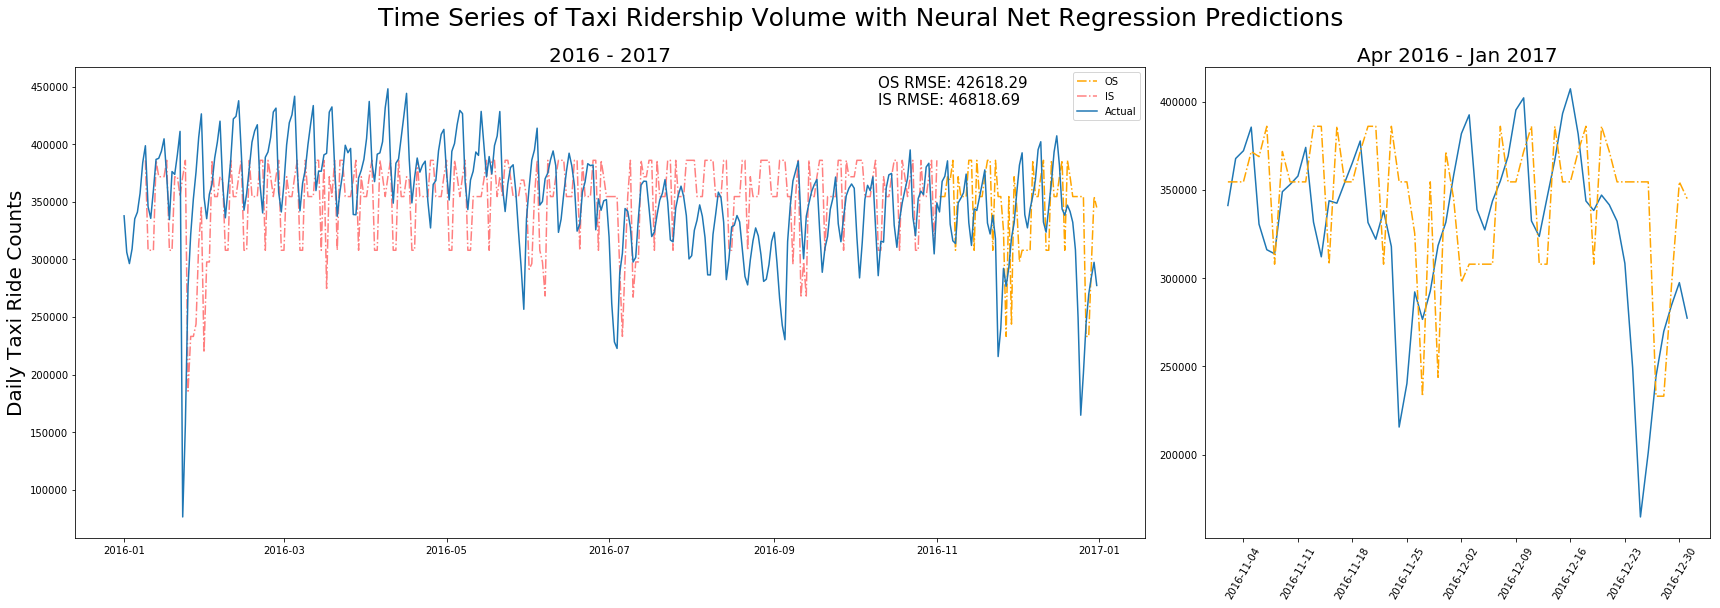

In [655]:
fig = plt.figure(figsize=(24, 8))

ax1 = fig.add_subplot(grid[:, :8])

ax1.plot(taxi_df_nn.iloc[-test_size:]["date"], preds, color="orange", linestyle="-.", label="OS")

ax1.plot(taxi_df_nn.iloc[8:-test_size]["date"], preds_, color="red", alpha=.5, linestyle="-.", label="IS")

ax1.plot(taxi_df_nn["date"], taxi_df_nn["sum"], label="Actual")

ax1.legend()

ax2 = fig.add_subplot(grid[:, 8:])

ax2.plot(taxi_df_nn.iloc[-test_size:]["date"], taxi_df_nn.iloc[-test_size:]["sum"])

ax2.plot(taxi_df_nn.iloc[-test_size:]["date"], preds, color="orange", linestyle="-.")

plt.xticks(rotation=60)

fig.suptitle("Time Series of Taxi Ridership Volume with Neural Net Regression Predictions", x = .5, y=1.05, size=25)

ax1.set_title("2016 - 2017", size=20)

ax2.set_title("Apr 2016 - Jan 2017", size=20)

ax1.set_ylabel("Daily Taxi Ride Counts", size=20)

ax1.text(x=.75, y=.92, transform=ax1.transAxes, s="OS RMSE: {}\nIS RMSE: {}".format(round(rmse_os, 2),\
                                                                                  round(rmse_is, 2)), size=15)

fig.tight_layout()

fig.savefig("taxi_timeseries_nn.png", b_box_inches="tight")